# Project: Wrangling and Analyze Data

In [1]:
import pandas as pd
import numpy as np

import requests
import os

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# regular expression
import re

import matplotlib.pyplot as plt
import seaborn as sb

from dateutil.parser import parse
from datetime import datetime

%matplotlib inline

In [2]:
def extract_urls_from_str(value)->str:
    """
    Extract urls the given string
    Return : urls, separated by comma
    
    References : 
        - https://www.digitalocean.com/community/tutorials/pandas-dataframe-apply-examples
        - https://stackoverflow.com/questions/499345/regular-expression-to-extract-url-from-an-html-link
    """
    string = str(value)
    urls = re.findall(r'href=[\'"]?([^\'" >]+)', string)
    return ', '.join(urls) 

In [3]:
def operate_datetime_feature_engineering(df:pd.DataFrame, datetime_column:str, verbose=False)->pd.DataFrame:
    """
        Generate new features for our samples, in order to answer questions related to :
            - day periods (morning, miday, evening, afternoon, ...)
            - day (monday, tuesday, ...)
            - month (Jan, Feb, ...)

        Code based on the courses given by Prof @Stanley Omeike on OneCampus Academy.
        
        @param df:pd.DataFrame : the dataframe in which to do the feature engineering
        @param datetime_column:str : column based on which to do the feature engineering
        
        @return : the new dataframe, containing the generated columns
        
        References :
            - Code based on a course given by Prof @Stanley Omeike on OneCampus Academy
            - https://sparkbyexamples.com/pandas/how-to-format-pandas-datetime/
            - https://stackoverflow.com/questions/1759455/how-can-i-account-for-period-am-pm-using-strftime
    """

    # standardize the format of the column, and parse it to str in order to allow further work on it
    dCol = tweets_master_df[datetime_column].dt.strftime("%Y-%m-%d %I:%M:%S %p").astype(str) #tweets_master_df["timestamp"].astype(str)
    #dCol

    # print(dates[:2] ) will give something like : [('Sat Jul 26 02:30:00 2008', 'PM'), ('Tue Jul 31 10:57:00 2018', 'AM')]
    dates = [( datetime.ctime(parse(x[0:-3])), x[-2:] ) for x in dCol]

#     print("dates[:2] : ")
#     print(dates[:2])
    
    days = []
    months = []
    periods = []

    unprocesseds = []

    for row in dates:
        day = row[0][0:4]
        month = row[0][4:7]
        time = int(row[0][11:13])

        if row[1]=='AM' and time<=4:
            period = 'Night (after midnight)'
        elif row[1]=='AM' and time<=7:
            period = "Morning"
        elif row[1]=='AM' and time>7:
            period = "Day Time"
        elif row[1] =='PM' and time<=4:
            period = 'Afternoon'
        elif row[1] =='PM' and time<=6:
            period = 'Evening' 
        elif row[1] =='PM' and (time>6 and time<=10):
            period = 'Night (start)'
        elif row[1] =='PM' and time>10:
            period = 'Near Midnight'
        else:
            period = "TODO"
            unprocesseds.append(row[0]+" "+row[1])

        days.append(day)
        months.append(month)
        periods.append(period)
    
    if(len(unprocesseds)>0):
        print("unprocesseds")
        print(unprocesseds)
        print("len(unprocesseds)")
        print(len(unprocesseds))
    
    df['month'] = months
    df['day'] = days
    df['period']= periods
    
    if(verbose):
        df.sample(3).T
        
    return df

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [4]:
twitter_archive_df = pd.read_csv("twitter-archive-enhanced.csv")
twitter_archive_df.head(3).T

,0,1,2
tweet_id,892420643555336193,892177421306343426,891815181378084864
in_reply_to_status_id,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 00:17:27 +0000,2017-07-31 00:18:03 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....,This is Archie. He is a rare Norwegian Pouncin...
retweeted_status_id,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892177421...,https://twitter.com/dog_rates/status/891815181...


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [5]:
# url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
# response = requests.get(url)

# fileName= url.split("/")[-1]
# with open( fileName , mode="wb" ) as file:
#     file.write(response.content)

In [6]:
# Create download folder if not exist
folder_name = "downloads"
folder_path = "./{}".format(folder_name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [7]:
# Make the download request

# download's url provided in the project's instructions
image_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
image_response = requests.get(image_url)

if image_response.status_code != 200:
    raise Exception("Response status code != from 200")
else:
    print("Request successful")

Request successful


In [8]:
# Save downloaded file
file_name = image_url.split("/")[-1]
file_path = os.path.join(folder_path, file_name)
with open( file_path , mode="wb" ) as file:
    file.write(image_response.content)
    print("File saved on disk")

File saved on disk


In [9]:
image_predictions_df = pd.read_csv(file_path, sep="\t")
image_predictions_df.head(3).T

,0,1,2
tweet_id,666020888022790149,666029285002620928,666033412701032449
jpg_url,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
img_num,1,1,1
p1,Welsh_springer_spaniel,redbone,German_shepherd
p1_conf,0.465074,0.506826,0.596461
p1_dog,True,True,True
p2,collie,miniature_pinscher,malinois
p2_conf,0.156665,0.074192,0.138584
p2_dog,True,True,True
p3,Shetland_sheepdog,Rhodesian_ridgeback,bloodhound


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [10]:
tweet_ids = image_predictions_df["tweet_id"].values
tweet_ids

array([666020888022790149, 666029285002620928, 666033412701032449, ...,
       891815181378084864, 892177421306343426, 892420643555336193],
      dtype=int64)

In [11]:
# Signify that I have not put my own twitter api key in this notebook
have_put_my_own_api_key = False

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = "XXX"
consumer_secret = "XXX"
access_token = "XXX"
access_secret = "XXX"

tweet_json_file_name = "tweet_json.txt"
tweet_json_file_path = "./{}".format(tweet_json_file_name)

if have_put_my_own_api_key:
    """ The code below was taken from my Udacity's classroom """
    
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth, wait_on_rate_limit=True)

    # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
    count = 0
    fails_dict = {}
    start = timer()
    # Save each tweet's returned JSON as a new line in a .txt file
    with open('tweet_json.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)

Import json file into a df

In [12]:
"""

References : 

- https://www.geeksforgeeks.org/read-json-file-using-python/
- https://www.pythontutorial.net/python-basics/python-read-text-file/
- https://www.freecodecamp.org/news/python-json-how-to-convert-a-string-to-json/

"""
df_list = []

# Open file
with open(tweet_json_file_path,"r") as file:
    #file_content = json.load(file)
    lines = file.readlines()
    #print(lines[0])
    #print(json.loads(lines[0])["created_at"])
    for line in lines:
         df_list.append(json.loads(line))

df_list[:2]

[{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
  'id': 892420643555336193,
  'id_str': '892420643555336193',
  'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
  'truncated': False,
  'display_text_range': [0, 85],
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [],
   'media': [{'id': 892420639486877696,
     'id_str': '892420639486877696',
     'indices': [86, 109],
     'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
     'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
     'url': 'https://t.co/MgUWQ76dJU',
     'display_url': 'pic.twitter.com/MgUWQ76dJU',
     'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
     'type': 'photo',
     'sizes': {'large': {'w': 540, 'h': 528, 'resize': 'fit'},
      'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
      'small': {'w': 540, 'h': 528, 'resize': 'fit'},

In [13]:
tweets_df = pd.DataFrame(df_list)
tweets_df.head(3).T

,0,1,2
created_at,Tue Aug 01 16:23:56 +0000 2017,Tue Aug 01 00:17:27 +0000 2017,Mon Jul 31 00:18:03 +0000 2017
id,892420643555336193,892177421306343426,891815181378084864
id_str,892420643555336193,892177421306343426,891815181378084864
full_text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....,This is Archie. He is a rare Norwegian Pouncin...
truncated,False,False,False
display_text_range,"[0, 85]","[0, 138]","[0, 121]"
entities,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'hashtags': [], 'symbols': [], 'user_mentions...","{'hashtags': [], 'symbols': [], 'user_mentions..."
extended_entities,"{'media': [{'id': 892420639486877696, 'id_str'...","{'media': [{'id': 892177413194625024, 'id_str'...","{'media': [{'id': 891815175371796480, 'id_str'..."
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
in_reply_to_status_id,NaN,NaN,NaN


In [14]:
# # Keep useful columns while discarding the others, as per the project instructions
# tweets_df = tweets_df[ ["id","retweet_count","favorite_count","user","retweeted"] ]
# tweets_df.head(3)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [15]:
# Looking at the content of twitter_archive_df
twitter_archive_df.head(3).T

,0,1,2
tweet_id,892420643555336193,892177421306343426,891815181378084864
in_reply_to_status_id,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 00:17:27 +0000,2017-07-31 00:18:03 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....,This is Archie. He is a rare Norwegian Pouncin...
retweeted_status_id,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892177421...,https://twitter.com/dog_rates/status/891815181...


In [16]:
# Looking at the structure of twitter_archive_df
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

We have wrong datatype in the timestamp column, it should be of type datetime

In [17]:
# Checking null values in twitter_archive_df
twitter_archive_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

* There are too much null values in many columns (compared to the total number of samples we have) : `in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp`.         
* `expanded_urls` also have some null values.

* The non-null value in the `retweeted_XXX` columns are marking that we we have retweet sample (we will further investivate this)

In [18]:
# Checking NaN (not a number) values in twitter_archive_df
twitter_archive_df.isna().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

The results for NaN check are the same as the results from null check, so there is nothing suspicious to investigate.

In [19]:
# Taking a look at the retweeted samples
twitter_archive_df[ ~ twitter_archive_df["retweeted_status_id"].isnull() ].T

,19,32,36,68,73,74,78,91,95,97,...,926,937,943,949,1012,1023,1043,1242,2259,2260
tweet_id,888202515573088257,886054160059072513,885311592912609280,879130579576475649,878404777348136964,878316110768087041,877611172832227328,874434818259525634,873697596434513921,873337748698140672,...,754874841593970688,753298634498793472,752701944171524096,752309394570878976,747242308580548608,746521445350707200,743835915802583040,711998809858043904,667550904950915073,667550882905632768
in_reply_to_status_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
timestamp,2017-07-21 01:02:36 +0000,2017-07-15 02:45:48 +0000,2017-07-13 01:35:06 +0000,2017-06-26 00:13:58 +0000,2017-06-24 00:09:53 +0000,2017-06-23 18:17:33 +0000,2017-06-21 19:36:23 +0000,2017-06-13 01:14:41 +0000,2017-06-11 00:25:14 +0000,2017-06-10 00:35:19 +0000,...,2016-07-18 03:06:01 +0000,2016-07-13 18:42:44 +0000,2016-07-12 03:11:42 +0000,2016-07-11 01:11:51 +0000,2016-06-27 01:37:04 +0000,2016-06-25 01:52:36 +0000,2016-06-17 16:01:16 +0000,2016-03-21 19:31:59 +0000,2015-11-20 03:51:52 +0000,2015-11-20 03:51:47 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...",...,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...","<a href=""http://twitter.com"" rel=""nofollow"">Tw..."
text,RT @dog_rates: This is Canela. She attempted s...,RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,RT @dog_rates: This is Lilly. She just paralle...,RT @dog_rates: This is Emmy. She was adopted t...,RT @dog_rates: Meet Shadow. In an attempt to r...,RT @dog_rates: Meet Terrance. He's being yelle...,RT @rachel2195: @dog_rates the boyfriend and h...,RT @dog_rates: This is Coco. At first I though...,RT @dog_rates: This is Walter. He won't start ...,RT @dog_rates: This is Sierra. She's one preci...,...,RT @dog_rates: This is Rubio. He has too much ...,RT @dog_rates: This is Carly. She's actually 2...,RT @dog_rates: HEY PUP WHAT'S THE PART OF THE ...,RT @dog_rates: Everyone needs to watch this. 1...,RT @dog_rates: This pupper killed this great w...,RT @dog_rates: This is Shaggy. He knows exactl...,RT @dog_rates: Extremely intelligent dog here....,RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,RT @dogratingrating: Exceptional talent. Origi...,RT @dogratingrating: Unoriginal idea. Blatant ...
retweeted_status_id,887473957103951872.0,886053734421102592.0,830583320585068544.0,878057613040115712.0,878281511006478336.0,669000397445533696.0,876850772322988032.0,866334964761202688.0,868880397819494400.0,873213775632977920.0,...,679158373988876288.0,681523177663676416.0,683515932363329536.0,675354435921575936.0,704761120771465216.0,667866724293877760.0,667138269671505920.0,711998279773347840.0,667548695664070656.0,667548415174144000.0
retweeted_status_user_id,4196983835.0,19607400.0,4196983835.0,4196983835.0,4196983835.0,4196983835.0,512804507.0,4196983835.0,4196983835.0,4196983835.0,...,4196983835.0,4196983835.0,4196983835.0,4196983835.0,4196983835.0,4196983835.0,

Those retweeted samples should not be present in our dataset, as per the projec instruction.

In [20]:
# Taking a look at the samples which have value in expanded_urls column
twitter_archive_df[ ~ twitter_archive_df["expanded_urls"].isnull() ].T

,0,1,2,3,4,5,6,7,8,9,...,2346,2347,2348,2349,2350,2351,2352,2353,2354,2355
tweet_id,892420643555336193,892177421306343426,891815181378084864,891689557279858688,891327558926688256,891087950875897856,890971913173991426,890729181411237888,890609185150312448,890240255349198849,...,666058600524156928,666057090499244032,666055525042405380,666051853826850816,666050758794694657,666049248165822465,666044226329800704,666033412701032449,666029285002620928,666020888022790149
in_reply_to_status_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 00:17:27 +0000,2017-07-31 00:18:03 +0000,2017-07-30 15:58:51 +0000,2017-07-29 16:00:24 +0000,2017-07-29 00:08:17 +0000,2017-07-28 16:27:12 +0000,2017-07-28 00:22:40 +0000,2017-07-27 16:25:51 +0000,2017-07-26 15:59:51 +0000,...,2015-11-16 01:01:59 +0000,2015-11-16 00:55:59 +0000,2015-11-16 00:49:46 +0000,2015-11-16 00:35:11 +0000,2015-11-16 00:30:50 +0000,2015-11-16 00:24:50 +0000,2015-11-16 00:04:52 +0000,2015-11-15 23:21:54 +0000,2015-11-15 23:05:30 +0000,2015-11-15 22:32:08 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...",...,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....,This is Archie. He is a rare Norwegian Pouncin...,This is Darla. She commenced a snooze mid meal...,This is Franklin. He would like you to stop ca...,Here we have a majestic great white breaching ...,Meet Jax. He enjoys ice cream so much he gets ...,When you watch your owner call another dog a g...,This is Zoey. She doesn't want to be one of th...,This is Cassie. She is a college pup. Studying...,...,Here is the Rand Paul of retrievers folks! He'...,My oh my. This is a rare blond Canadian terrie...,Here is a Siberian heavily armored polar bear ...,This is an odd dog. Hard on the outside but lo...,This is a truly beautiful English Wilson Staff...,Here we have a 1949 1st generation vulpix. Enj...,This is a purebred Piers Morgan. Loves to Netf...,Here is a very happy pup. Big fan of well-main...,This is a western brown Mitsubishi terrier. Up...,Here we have a Japanese Irish Setter. Lost eye...
retweeted_status_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892177421...,https://twitter.com/dog_rates/status/891815181...,https://twitter.com/dog_rates/status/891689557...,https://twitter.com/dog_rates/status/891327558...,https://twitter.com/dog_rates/status/891087950...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...

In [21]:
# Assessing the content of twitter_archive_df["source"]
twitter_archive_df["source"].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

Everything seem ok here.

In [22]:
# Looking at the content of tweets_df
tweets_df.head(3).T

,0,1,2
created_at,Tue Aug 01 16:23:56 +0000 2017,Tue Aug 01 00:17:27 +0000 2017,Mon Jul 31 00:18:03 +0000 2017
id,892420643555336193,892177421306343426,891815181378084864
id_str,892420643555336193,892177421306343426,891815181378084864
full_text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....,This is Archie. He is a rare Norwegian Pouncin...
truncated,False,False,False
display_text_range,"[0, 85]","[0, 138]","[0, 121]"
entities,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'hashtags': [], 'symbols': [], 'user_mentions...","{'hashtags': [], 'symbols': [], 'user_mentions..."
extended_entities,"{'media': [{'id': 892420639486877696, 'id_str'...","{'media': [{'id': 892177413194625024, 'id_str'...","{'media': [{'id': 891815175371796480, 'id_str'..."
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
in_reply_to_status_id,NaN,NaN,NaN


In [23]:
# Looking at the structure of tweets_df
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2354 non-null   object 
 1   id                             2354 non-null   int64  
 2   id_str                         2354 non-null   object 
 3   full_text                      2354 non-null   object 
 4   truncated                      2354 non-null   bool   
 5   display_text_range             2354 non-null   object 
 6   entities                       2354 non-null   object 
 7   extended_entities              2073 non-null   object 
 8   source                         2354 non-null   object 
 9   in_reply_to_status_id          78 non-null     float64
 10  in_reply_to_status_id_str      78 non-null     object 
 11  in_reply_to_user_id            78 non-null     float64
 12  in_reply_to_user_id_str        78 non-null     o

In [24]:
# Looking at the content of image_predictions_df
image_predictions_df.tail(3).T

,2072,2073,2074
tweet_id,891815181378084864,892177421306343426,892420643555336193
jpg_url,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
img_num,1,1,1
p1,Chihuahua,Chihuahua,orange
p1_conf,0.716012,0.323581,0.097049
p1_dog,True,True,False
p2,malamute,Pekinese,bagel
p2_conf,0.078253,0.090647,0.085851
p2_dog,True,True,False
p3,kelpie,papillon,banana


In [25]:
# Observing the structure of image_predictions_df
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:
# sum(tweets_df.duplicated())

### Tidiness issues
1. `twitter_archive_df` and `tweets_df` should form one dataframe instead being two different dataframes.

1. `twitter_archive_df` has values as columns for the stage of the dog.

1. `twitter_archive_df` has useless columns for our purpose, such as status_id, status_user_id, status_timestamp, ...

1. `tweets_df.user` should contains the id of another dataframe named `user`.

1. `twitter_archive_df` and `image_predictions_df` should form one dataframe instead being two different dataframes.

### Quality issues 
1. `twitter_archive_df['source']` has tag `a` as value instead of the value of `href` attribute

1. Wrong datatypes in `twitter_archive_df` in the following columns : `timestamp`

1. `twitter_archive_df` has retweet samples, which are useless for our purpose (according to the project instructions)

1. Null values in the following columns of `twitter_archive_df` : `in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls`.

1. Useless columns in `tweet_df`

1. `tweets_df.created` has value beyond August 1st, 2017, which mean those sample will not have corresponding value in image_predictions_df

1. Some samples in `image_predictions_df` are not dog

1. In columns `p1`, `p2`, and `p3` of `image_predictions_df`, some values are capitalized while others are not

1. In `image_predictions_df`, only the most confident prediction is relevant


## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

Make copies of original image_predictions_df. It is useless to make copy of the others dataframe since they will be merged

In [27]:
# Make copies of original image_predictions_df

#tweets_clean = tweets_df.copy()
#twitter_archive_clean = twitter_archive_df.copy()
image_predictions_clean = image_predictions_df.copy()


### Issue #5 (quality) : Useless columns in `tweets_df`

In [28]:
tweets_df.head(2).T

,0,1
created_at,Tue Aug 01 16:23:56 +0000 2017,Tue Aug 01 00:17:27 +0000 2017
id,892420643555336193,892177421306343426
id_str,892420643555336193,892177421306343426
full_text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....
truncated,False,False
display_text_range,"[0, 85]","[0, 138]"
entities,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'hashtags': [], 'symbols': [], 'user_mentions..."
extended_entities,"{'media': [{'id': 892420639486877696, 'id_str'...","{'media': [{'id': 892177413194625024, 'id_str'..."
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
in_reply_to_status_id,NaN,NaN


#### Define
In `tweets_df`, only keep `"id","retweet_count","favorite_count","user","retweeted"` as useful columns

#### Code

In [29]:
# Keep useful columns while discarding the others, as per the project instructions
tweets_df = tweets_df[ ["id","retweet_count","favorite_count","user","retweeted"] ]

#### Test

In [30]:
tweets_df.head(3)

,id,retweet_count,favorite_count,user,retweeted
0,892420643555336193,8853,39467,"{'id': 4196983835, 'id_str': '4196983835', 'na...",False
1,892177421306343426,6514,33819,"{'id': 4196983835, 'id_str': '4196983835', 'na...",False
2,891815181378084864,4328,25461,"{'id': 4196983835, 'id_str': '4196983835', 'na...",False


### Issue #1 (tidiness): `twitter_archive_df` and `tweets_df` should form one dataframe instead being two different dataframes.

In [31]:
twitter_archive_df.head(2).T

,0,1
tweet_id,892420643555336193,892177421306343426
in_reply_to_status_id,NaN,NaN
in_reply_to_user_id,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 00:17:27 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....
retweeted_status_id,NaN,NaN
retweeted_status_user_id,NaN,NaN
retweeted_status_timestamp,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892177421...


In [32]:
twitter_archive_df.shape

(2356, 17)

In [33]:
tweets_df.head()

,id,retweet_count,favorite_count,user,retweeted
0,892420643555336193,8853,39467,"{'id': 4196983835, 'id_str': '4196983835', 'na...",False
1,892177421306343426,6514,33819,"{'id': 4196983835, 'id_str': '4196983835', 'na...",False
2,891815181378084864,4328,25461,"{'id': 4196983835, 'id_str': '4196983835', 'na...",False
3,891689557279858688,8964,42908,"{'id': 4196983835, 'id_str': '4196983835', 'na...",False
4,891327558926688256,9774,41048,"{'id': 4196983835, 'id_str': '4196983835', 'na...",False


In [34]:
tweets_df.shape

(2354, 5)

#### Define
Merge `twitter_archive_df` and `tweets_df` in one dataframe

#### Code

In [35]:
# All columns in the two datasets
# all_columns = pd.Series(list(twitter_archive_clean) + list(tweets_clean) )
# all_columns

In [36]:
# Find duplicated columns
# duplicated_columns = all_columns[all_columns.duplicated()]
# duplicated_columns

In [37]:
# Drop duplicated columns from tweets_clean
# tweets_clean.drop(duplicated_columns, axis=1, inplace=True)
# tweets_clean.head(2).T

In [38]:
# tweets_clean.shape

In [39]:
# Merging the two dataset

# https://stackoverflow.com/questions/43297589/merge-two-data-frames-based-on-common-column-values-in-pandas
twitter_df = twitter_archive_df.merge(tweets_df, how="inner",left_on="tweet_id", right_on="id")
twitter_df.shape

(2354, 22)

#### Test

In [40]:
twitter_df.head(2).T

,0,1
tweet_id,892420643555336193,892177421306343426
in_reply_to_status_id,NaN,NaN
in_reply_to_user_id,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 00:17:27 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....
retweeted_status_id,NaN,NaN
retweeted_status_user_id,NaN,NaN
retweeted_status_timestamp,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892177421...


In [41]:
# Making sure the merge worked fine
twitter_df.shape[1] == twitter_archive_df.shape[1] + tweets_df.shape[1]

True

In [42]:
# Dropping redundant id column
twitter_df.drop(["id"],axis=1, inplace=True)
twitter_df.head(2).T

,0,1
tweet_id,892420643555336193,892177421306343426
in_reply_to_status_id,NaN,NaN
in_reply_to_user_id,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 00:17:27 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....
retweeted_status_id,NaN,NaN
retweeted_status_user_id,NaN,NaN
retweeted_status_timestamp,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892177421...


### Issue #2 (tidiness): `twitter_archive_df` has values as columns for the stage of the dog.          
Those columns are `doggo, floofer, pupper, puppo`

In [43]:
twitter_df.head(3).T

,0,1,2
tweet_id,892420643555336193,892177421306343426,891815181378084864
in_reply_to_status_id,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 00:17:27 +0000,2017-07-31 00:18:03 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....,This is Archie. He is a rare Norwegian Pouncin...
retweeted_status_id,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892177421...,https://twitter.com/dog_rates/status/891815181...


#### Define
Melt the dog stage columns into a column which name will be `stage` and which value will be the stage of the dog or NaN depending on weither the stage is known or not.

#### Code

In [44]:
id_vars = twitter_df.columns.tolist()
id_vars.remove("doggo")
id_vars.remove("floofer")
id_vars.remove("pupper")
id_vars.remove("puppo")
id_vars

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'retweet_count',
 'favorite_count',
 'user',
 'retweeted']

In [45]:
melted = pd.melt(twitter_df, id_vars=id_vars, var_name="stage", value_name="stage_value")
melted.head(3).T

,0,1,2
tweet_id,892420643555336193,892177421306343426,891815181378084864
in_reply_to_status_id,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 00:17:27 +0000,2017-07-31 00:18:03 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....,This is Archie. He is a rare Norwegian Pouncin...
retweeted_status_id,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892177421...,https://twitter.com/dog_rates/status/891815181...


Looking at our dataframe, we don't need the `stage_value` column, so will drop it in a while after performing some tidiness cleaning.

In [46]:
melted.shape

(9416, 19)

In [47]:
# twitter_df.shape

**Analyzing the content of `melted` based on weither the stage of the dog is known or not**

In [48]:
# Visual assessement of the tweet which id is 892420643555336193 (this tweet dog stage is unknow)
melted[ melted["tweet_id"]==892420643555336193 ].T

,0,2354,4708,7062
tweet_id,892420643555336193,892420643555336193,892420643555336193,892420643555336193
in_reply_to_status_id,NaN,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 16:23:56 +0000,2017-08-01 16:23:56 +0000,2017-08-01 16:23:56 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Phineas. He's a mystical boy. Only eve...,This is Phineas. He's a mystical boy. Only eve...,This is Phineas. He's a mystical boy. Only eve...,This is Phineas. He's a mystical boy. Only eve...
retweeted_status_id,NaN,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892420643...


We have 04 entries for the same tweet_id, each corresponding to one of the 04 melted columns. 

Let's separate `melted` in two different dataframes for a better observation 

In [49]:
# Retrieve the tweets with known dog stage
tweets_with_stage_df = melted[ melted["stage_value"] !="None" ]
tweets_with_stage_df.head(3).T

,9,42,98
tweet_id,890240255349198849,884162670584377345,872967104147763200
in_reply_to_status_id,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN
timestamp,2017-07-26 15:59:51 +0000,2017-07-09 21:29:42 +0000,2017-06-09 00:02:31 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Cassie. She is a college pup. Studying...,Meet Yogi. He doesn't have any important dog m...,Here's a very large dog. He has a date later. ...
retweeted_status_id,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/890240255...,https://twitter.com/dog_rates/status/884162670...,https://twitter.com/dog_rates/status/872967104...


In [50]:
# Visual assessement of a tweet with known dog stage
tweets_with_stage_df[ tweets_with_stage_df["tweet_id"]==890240255349198849 ].T

,9
tweet_id,890240255349198849
in_reply_to_status_id,NaN
in_reply_to_user_id,NaN
timestamp,2017-07-26 15:59:51 +0000
source,"<a href=""http://twitter.com/download/iphone"" r..."
text,This is Cassie. She is a college pup. Studying...
retweeted_status_id,NaN
retweeted_status_user_id,NaN
retweeted_status_timestamp,NaN
expanded_urls,https://twitter.com/dog_rates/status/890240255...


We can confirm that there is only one entry for the tweets when dog stage is known. 

In [51]:
# Retrieve the tweets with unknown dog stage
tweets_without_stage_df = melted[ melted["stage_value"] =="None" ]
tweets_without_stage_df.head(3).T

,0,1,2
tweet_id,892420643555336193,892177421306343426,891815181378084864
in_reply_to_status_id,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 00:17:27 +0000,2017-07-31 00:18:03 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....,This is Archie. He is a rare Norwegian Pouncin...
retweeted_status_id,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892177421...,https://twitter.com/dog_rates/status/891815181...


In [52]:
# Visual assessement of a tweet with unknown dog stage
tweets_without_stage_df[ tweets_without_stage_df["tweet_id"]==892420643555336193 ].T

,0,2354,4708,7062
tweet_id,892420643555336193,892420643555336193,892420643555336193,892420643555336193
in_reply_to_status_id,NaN,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 16:23:56 +0000,2017-08-01 16:23:56 +0000,2017-08-01 16:23:56 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Phineas. He's a mystical boy. Only eve...,This is Phineas. He's a mystical boy. Only eve...,This is Phineas. He's a mystical boy. Only eve...,This is Phineas. He's a mystical boy. Only eve...
retweeted_status_id,NaN,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892420643...


We can observe that there is 04 entries (same number as the number of columns melted) for the tweets when dog stage is unknown.

Now we will :
* replace the values in `tweets_without_stage_df["stage"]` by "others"
* concatenate `tweets_without_stage_df` to `tweets_with_stage_df`

In [53]:
# Giving NaN values to stage column in tweets_without_stage_df
tweets_without_stage_df["stage"] = "others"
tweets_without_stage_df.head(2).T

<ipython-input-53-f530d07946d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_without_stage_df["stage"] = "others"


,0,1
tweet_id,892420643555336193,892177421306343426
in_reply_to_status_id,NaN,NaN
in_reply_to_user_id,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 00:17:27 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....
retweeted_status_id,NaN,NaN
retweeted_status_user_id,NaN,NaN
retweeted_status_timestamp,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892177421...


In [54]:
tweets_without_stage_df.shape

(9023, 19)

In [55]:
# Drop duplicate value by tweet_id in tweets_without_stage_df
tweets_without_stage_df.drop_duplicates(subset="tweet_id",inplace=True)
tweets_without_stage_df.shape

<ipython-input-55-844b4621f32a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_without_stage_df.drop_duplicates(subset="tweet_id",inplace=True)


(2354, 19)

In [56]:
# Concat tweets_without_stage_df and tweets_with_stage_df, in order to form a whole again
twitter_clean = pd.concat([tweets_with_stage_df,tweets_without_stage_df], axis=0, ignore_index=True)

# Shuffling the dataframe in order to eliminate an eventual bias
"""Reference : https://datagy.io/pandas-shuffle-dataframe/ """
random_state_seed = 5 # set seed for reproducibility
twitter_clean = twitter_clean.sample(frac=1, random_state=random_state_seed).reset_index()


twitter_clean.head(3).T

,0,1,2
index,1435,1067,1340
tweet_id,728046963732717569,781661882474196992,745057283344719872
in_reply_to_status_id,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN
timestamp,2016-05-05 02:21:37 +0000,2016-09-30 01:08:10 +0000,2016-06-21 00:54:33 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Raymond. He controls fountains with hi...,Who keeps sending in pictures without dogs in ...,This is Oliver. He's downright gorgeous as hel...
retweeted_status_id,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN


Looking at our dataframe, we don't need the `stage_value` column anymore, so will drop it. We will also drop `index` column, because it is the original index of the samples before the shuffled.

In [57]:
twitter_df = twitter_clean.drop(["stage_value","index"],axis=1)
twitter_df.head(3).T

,0,1,2
tweet_id,728046963732717569,781661882474196992,745057283344719872
in_reply_to_status_id,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN
timestamp,2016-05-05 02:21:37 +0000,2016-09-30 01:08:10 +0000,2016-06-21 00:54:33 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Raymond. He controls fountains with hi...,Who keeps sending in pictures without dogs in ...,This is Oliver. He's downright gorgeous as hel...
retweeted_status_id,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/728046963...,https://twitter.com/dog_rates/status/781661882...,https://twitter.com/dog_rates/status/745057283...


#### Test

In [58]:
# Checking the occurences in twitter_df["stage"]
twitter_df["stage"].unique()

array(['others', 'pupper', 'doggo', 'puppo', 'floofer'], dtype=object)

In [59]:
# Checking the repartition of the dog per their stage
twitter_df["stage"].value_counts()

others     2354
pupper      256
doggo        97
puppo        30
floofer      10
Name: stage, dtype: int64

In [60]:
# Checking for duplicate 

# the user column is (temporarly) removed from the duplicate checking in order to avoid "unhashable type: 'dict'" error
#   when using dataframe.duplicated()
twitter_df.drop(["user"],axis=1).duplicated().sum()

0


<!-- Now we will check the number of column in each of our twitter dataset (the original, and the new) -->

### Issue #3 (tidiness): `twitter_archive_df` has useless columns for our purpose          
Those columns are `status_id, status_user_id, status_timestamp`.   

Our cleaning is to be performed in `twitter_df`

In [61]:
# Recalling the content of our df
twitter_df.head(2).T

,0,1
tweet_id,728046963732717569,781661882474196992
in_reply_to_status_id,NaN,NaN
in_reply_to_user_id,NaN,NaN
timestamp,2016-05-05 02:21:37 +0000,2016-09-30 01:08:10 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Raymond. He controls fountains with hi...,Who keeps sending in pictures without dogs in ...
retweeted_status_id,NaN,NaN
retweeted_status_user_id,NaN,NaN
retweeted_status_timestamp,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/728046963...,https://twitter.com/dog_rates/status/781661882...


#### Define

Remove columns deemed useless for our purpose from `twitter_df` : `in_reply_to_status_id, in_reply_to_user_id, expanded_urls`.

#### Code

In [62]:
useless_columns = ["in_reply_to_status_id","in_reply_to_user_id","expanded_urls"]
twitter_df.drop(useless_columns, axis=1, inplace=True)

#### Test

In [63]:
# Making sure the dropped columns no longer exist
twitter_df.head(2).T

,0,1
tweet_id,728046963732717569,781661882474196992
timestamp,2016-05-05 02:21:37 +0000,2016-09-30 01:08:10 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Raymond. He controls fountains with hi...,Who keeps sending in pictures without dogs in ...
retweeted_status_id,NaN,NaN
retweeted_status_user_id,NaN,NaN
retweeted_status_timestamp,NaN,NaN
rating_numerator,11,5
rating_denominator,10,10
name,Raymond,None


### Issue #4 (tidiness): `tweets_df.user` should contains the id of another dataframe named `user`

The cleaning it to be performed in `twitter_df`

In [64]:
twitter_df.head(3).T

,0,1,2
tweet_id,728046963732717569,781661882474196992,745057283344719872
timestamp,2016-05-05 02:21:37 +0000,2016-09-30 01:08:10 +0000,2016-06-21 00:54:33 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Raymond. He controls fountains with hi...,Who keeps sending in pictures without dogs in ...,This is Oliver. He's downright gorgeous as hel...
retweeted_status_id,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN
rating_numerator,11,5,12
rating_denominator,10,10,10
name,Raymond,None,Oliver


#### Define
* Extract values from `twitter_df["user"]`, and use them to populate a new `user_df` dataframe
* Replace each value from `twitter_df["user"]` by the user_id
* Remove duplicated samples from `user_df`

#### Code

In [65]:
# Retrieve users data from twitter_df["user"]
user_list = twitter_df["user"].values.tolist()
user_list[1]

{'id': 4196983835,
 'id_str': '4196983835',
 'name': 'WeRateDogs™ (author)',
 'screen_name': 'dog_rates',
 'location': 'DM YOUR DOGS, WE WILL RATE',
 'description': '#1 Source for Professional Dog Ratings | STORE: @ShopWeRateDogs | IG, FB & SC: WeRateDogs MOBILE APP: @GoodDogsGame | Business: dogratingtwitter@gmail.com',
 'url': 'https://t.co/N7sNNHAEXS',
 'entities': {'url': {'urls': [{'url': 'https://t.co/N7sNNHAEXS',
     'expanded_url': 'http://weratedogs.com',
     'display_url': 'weratedogs.com',
     'indices': [0, 23]}]},
  'description': {'urls': []}},
 'protected': False,
 'followers_count': 3200901,
 'friends_count': 104,
 'listed_count': 2789,
 'created_at': 'Sun Nov 15 21:41:29 +0000 2015',
 'favourites_count': 114031,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': True,
 'statuses_count': 5288,
 'lang': 'en',
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': '000000',
 'prof

In [66]:
# Create user dataframe
user_df = pd.DataFrame(user_list)
user_df.head(2).T

,0,1
id,4196983835,4196983835
id_str,4196983835,4196983835
name,WeRateDogs™ (author),WeRateDogs™ (author)
screen_name,dog_rates,dog_rates
location,"DM YOUR DOGS, WE WILL RATE","DM YOUR DOGS, WE WILL RATE"
description,#1 Source for Professional Dog Ratings | STORE...,#1 Source for Professional Dog Ratings | STORE...
url,https://t.co/N7sNNHAEXS,https://t.co/N7sNNHAEXS
entities,{'url': {'urls': [{'url': 'https://t.co/N7sNNH...,{'url': {'urls': [{'url': 'https://t.co/N7sNNH...
protected,False,False
followers_count,3200944,3200901


In [67]:
user_df.drop(["entities"],axis=1,inplace=True)

In [68]:
user_df.shape

(2747, 41)

In [69]:
user_df.drop_duplicates(inplace=True)

In [70]:
user_df.shape

(79, 41)

In [71]:
user_df["id"].unique()

array([4196983835], dtype=int64)

We are noticing that all entries in `user_df` are about one user. This should be related to the fact it is additionnal data describing the state, and not the attributes, of the users which were stored in `twitter_df["user"]`; this can be explained by how NoSQL databases are usually designed.      
Given the situation, `user_df` is of no more use to use, so we will discard it.                
Given the situation `twitter_df["user"]` should contain data related to only one user_id. We cannot help but wondering if it is useful to us as a column, and if user mean a person or something like a terminal/source ip.

In [72]:
twitter_df.head(2).T

,0,1
tweet_id,728046963732717569,781661882474196992
timestamp,2016-05-05 02:21:37 +0000,2016-09-30 01:08:10 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Raymond. He controls fountains with hi...,Who keeps sending in pictures without dogs in ...
retweeted_status_id,NaN,NaN
retweeted_status_user_id,NaN,NaN
retweeted_status_timestamp,NaN,NaN
rating_numerator,11,5
rating_denominator,10,10
name,Raymond,None


In [73]:
# Forming a new column containing the user_id
twitter_df["user_id"] = twitter_df["user"].apply(lambda x: x["id"])
twitter_df.sample(10).T

,2089,34,2311,836,1072,2104,162,686,1947,1917
tweet_id,786233965241827333,671186162933985280,868639477480148993,708400866336894977,685169283572338688,739485634323156992,666691418707132416,750381685133418496,674644256330530816,870726314365509632
timestamp,2016-10-12 15:55:59 +0000,2015-11-30 04:37:05 +0000,2017-05-28 01:26:04 +0000,2016-03-11 21:15:02 +0000,2016-01-07 18:41:01 +0000,2016-06-05 15:54:48 +0000,2015-11-17 18:56:35 +0000,2016-07-05 17:31:49 +0000,2015-12-09 17:38:19 +0000,2017-06-02 19:38:25 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://vine.co"" rel=""nofollow"">Vine -...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Mattie. She's extremely dangerous. Wil...,This is Sparky. That's his pancake now. He wil...,RT @dog_rates: Say hello to Cooper. His expres...,RT if you are as ready for summer as this pup ...,Meet Gerbald. He just found out he's adopted. ...,This is Kyle. He's a heavy drinker and an avid...,This is Christoper. He is a spotted Penne. Can...,13/10 such a good doggo\n@spaghemily,When you see sophomores in high school driving...,@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...
retweeted_status_id,NaN,NaN,868552278524837888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,4196983835.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,2017-05-27 19:39:34 +0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating_numerator,11,10,12,12,11,6,8,13,11,10
rating_denominator,10,10,10,10,10,10,10,10,10,10
name,Mattie,Sparky,Cooper,None,Gerbald,Kyle,Christoper,None,None,None


In [74]:
# Confirming that we have the same user_id in our dataframe
twitter_df["user_id"].unique()

array([4196983835], dtype=int64)

Since we have the same user_id in `twitter_df["user_id"]`, this column is no more useful in our analysis. We will drop it.

In [75]:
# def extract_keysvalue_from_json(json_data:dict, dict_key:str):
#     """
#         Retrieve the value of a given key from a json data
        
#         @param json_data:str : the json from which to extract the given key's value
#         @param dict_key:str : the key which value we wish to extract from the dictionnary 
#     """
#     return json_data[dict_key] #json.loads(json_data)[dict_key]

In [76]:
# Drop user column, since it is no more useful
twitter_df.drop(["user","user_id"],axis=1,inplace=True)

#### Test

In [77]:
twitter_df.head(2).T

,0,1
tweet_id,728046963732717569,781661882474196992
timestamp,2016-05-05 02:21:37 +0000,2016-09-30 01:08:10 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Raymond. He controls fountains with hi...,Who keeps sending in pictures without dogs in ...
retweeted_status_id,NaN,NaN
retweeted_status_user_id,NaN,NaN
retweeted_status_timestamp,NaN,NaN
rating_numerator,11,5
rating_denominator,10,10
name,Raymond,None


### Issue #1 (quality issue) : `twitter_archive_df['source']` has tag `a` as value instead of the value of `href` attribute

The cleaning is to be performed in `twitter_df`

#### Define
Extract href value from `twitter_df["source"]` occurences, and use it to replace tag `a`

#### Code

In [78]:
# Recalling the content of our dataset
twitter_df.head(2).T

,0,1
tweet_id,728046963732717569,781661882474196992
timestamp,2016-05-05 02:21:37 +0000,2016-09-30 01:08:10 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Raymond. He controls fountains with hi...,Who keeps sending in pictures without dogs in ...
retweeted_status_id,NaN,NaN
retweeted_status_user_id,NaN,NaN
retweeted_status_timestamp,NaN,NaN
rating_numerator,11,5
rating_denominator,10,10
name,Raymond,None


In [79]:
twitter_df["source"][0]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [80]:
twitter_df.loc[1,"source"]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [81]:
twitter_df["source"].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [82]:
# Clean source column
twitter_df["source"] = twitter_df["source"].apply(extract_urls_from_str)
twitter_df.head(2).T

,0,1
tweet_id,728046963732717569,781661882474196992
timestamp,2016-05-05 02:21:37 +0000,2016-09-30 01:08:10 +0000
source,http://twitter.com/download/iphone,http://twitter.com/download/iphone
text,This is Raymond. He controls fountains with hi...,Who keeps sending in pictures without dogs in ...
retweeted_status_id,NaN,NaN
retweeted_status_user_id,NaN,NaN
retweeted_status_timestamp,NaN,NaN
rating_numerator,11,5
rating_denominator,10,10
name,Raymond,None


#### Test

In [83]:
# Checking that the values of twitter_archive_clean["source"] are links (and no more tags)
twitter_df["source"].unique()

array(['http://twitter.com/download/iphone', 'http://vine.co',
       'http://twitter.com',
       'https://about.twitter.com/products/tweetdeck'], dtype=object)

### Issue #2 (quality issue): Wrong datatypes in `twitter_archive_df["timestamp"]`            
The datatypes in `twitter_archive_df["timestamp"]` should be datetime, not object(string).

This cleaning is to be performed in `twitter_df`.

In [84]:
# Recalling the structure of twitter_df
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2747 non-null   int64  
 1   timestamp                   2747 non-null   object 
 2   source                      2747 non-null   object 
 3   text                        2747 non-null   object 
 4   retweeted_status_id         216 non-null    float64
 5   retweeted_status_user_id    216 non-null    float64
 6   retweeted_status_timestamp  216 non-null    object 
 7   rating_numerator            2747 non-null   int64  
 8   rating_denominator          2747 non-null   int64  
 9   name                        2747 non-null   object 
 10  retweet_count               2747 non-null   int64  
 11  favorite_count              2747 non-null   int64  
 12  retweeted                   2747 non-null   bool   
 13  stage                       2747 

#### Define    
Convert `twitter_df["timestamp"]` to datetime.

#### Code

In [85]:
twitter_df["timestamp"] = pd.to_datetime(twitter_df["timestamp"])

#### Test

In [86]:
# Confirming that timestamp column was converted to datetime
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2747 non-null   int64              
 1   timestamp                   2747 non-null   datetime64[ns, UTC]
 2   source                      2747 non-null   object             
 3   text                        2747 non-null   object             
 4   retweeted_status_id         216 non-null    float64            
 5   retweeted_status_user_id    216 non-null    float64            
 6   retweeted_status_timestamp  216 non-null    object             
 7   rating_numerator            2747 non-null   int64              
 8   rating_denominator          2747 non-null   int64              
 9   name                        2747 non-null   object             
 10  retweet_count               2747 non-null   int64           

### Issue #3 (quality issue): `twitter_archive_df` has retweet samples

Those sample are useless for our purpose (according to the project instructions).                 
The cleaning is to be performed in `twitter_df`

In [87]:
# Taking a look at the retweeted samples
retweeted_mask = ~ twitter_df["retweeted_status_id"].isnull()
twitter_df[ retweeted_mask ].head(2).T

,6,8
tweet_id,775898661951791106,799308762079035393
timestamp,2016-09-14 03:27:11+00:00,2016-11-17 17:50:33+00:00
source,http://twitter.com/download/iphone,http://twitter.com/download/iphone
text,"RT @dog_rates: Like father (doggo), like son (...",RT @dog_rates: I WAS SENT THE ACTUAL DOG IN TH...
retweeted_status_id,733109485275860992.0,774314403806253056.0
retweeted_status_user_id,4196983835.0,4196983835.0
retweeted_status_timestamp,2016-05-19 01:38:16 +0000,2016-09-09 18:31:54 +0000
rating_numerator,12,14
rating_denominator,10,10
name,None,None


#### Define
* Retrieve retweeted samples in a `retweeted_df` dataframe
* Drop from `twitter_df` indexes of the samples coming from `retweeted_df`

In [88]:
retweeted_df = twitter_df[ retweeted_mask ]
retweeted_df.head(5).T

,6,8,14,17,18
tweet_id,775898661951791106,799308762079035393,776249906839351296,840728873075638272,817181837579653120
timestamp,2016-09-14 03:27:11+00:00,2016-11-17 17:50:33+00:00,2016-09-15 02:42:54+00:00,2017-03-12 00:59:17+00:00,2017-01-06 01:31:47+00:00
source,http://twitter.com/download/iphone,http://twitter.com/download/iphone,http://twitter.com/download/iphone,http://twitter.com/download/iphone,http://twitter.com/download/iphone
text,"RT @dog_rates: Like father (doggo), like son (...",RT @dog_rates: I WAS SENT THE ACTUAL DOG IN TH...,RT @dog_rates: We only rate dogs. Pls stop sen...,RT @dog_rates: This is Pipsy. He is a fluffbal...,RT @dog_rates: Here's a pupper with squeaky hi...
retweeted_status_id,733109485275860992.0,774314403806253056.0,700747788515020800.0,667152164079423488.0,815966073409433600.0
retweeted_status_user_id,4196983835.0,4196983835.0,4196983835.0,4196983835.0,4196983835.0
retweeted_status_timestamp,2016-05-19 01:38:16 +0000,2016-09-09 18:31:54 +0000,2016-02-19 18:24:26 +0000,2015-11-19 01:27:25 +0000,2017-01-02 17:00:46 +0000
rating_numerator,12,14,11,12,13
rating_denominator,10,10,10,10,10
name,None,None,very,Pipsy,None


In [89]:
retweeted_indexes = retweeted_df.index
retweeted_indexes

Int64Index([   6,    8,   14,   17,   18,   31,   71,   87,   88,   99,
            ...
            2631, 2633, 2636, 2670, 2676, 2683, 2707, 2711, 2715, 2728],
           dtype='int64', length=216)

In [90]:
twitter_df.shape

(2747, 14)

In [91]:
# Drop samples which are retweets
twitter_df.drop(retweeted_indexes, axis=0,inplace=True)

In [92]:
twitter_df.shape

(2531, 14)

We also have a `retweeted` column, which is no more useful.

In [93]:
twitter_df["retweeted"].unique()

array([False])

We will drop `retweeted` column, because it become useless since we know that we don't have any retweeted sample.

In [94]:
twitter_df.drop(["retweeted"], axis=1,inplace=True)

In [95]:
twitter_df.shape

(2531, 13)

#### Test

In [96]:
# Making sure there is no more retweet samples
twitter_df[ retweeted_mask ]

<ipython-input-96-e327e61058bd>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  twitter_df[ retweeted_mask ]


,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


### Issue #4 (quality issue): Null values in many columns in `twitter_archive_df`    

Null values in the `retweeted_XXXX` columns following columns of `twitter_archive_df`

The cleaning is to be performed in `twitter_df`.

In [97]:
# Recalling the structure of twitter_archive_clean
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 0 to 2746
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2531 non-null   int64              
 1   timestamp                   2531 non-null   datetime64[ns, UTC]
 2   source                      2531 non-null   object             
 3   text                        2531 non-null   object             
 4   retweeted_status_id         0 non-null      float64            
 5   retweeted_status_user_id    0 non-null      float64            
 6   retweeted_status_timestamp  0 non-null      object             
 7   rating_numerator            2531 non-null   int64              
 8   rating_denominator          2531 non-null   int64              
 9   name                        2531 non-null   object             
 10  retweet_count               2531 non-null   int64           

#### Define
Drop the `retweeted_XXXX` columns

#### Code

In [98]:
useless_columns=["retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp"]
twitter_df.drop(useless_columns, axis=1, inplace=True)

#### Test

In [99]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 0 to 2746
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2531 non-null   int64              
 1   timestamp           2531 non-null   datetime64[ns, UTC]
 2   source              2531 non-null   object             
 3   text                2531 non-null   object             
 4   rating_numerator    2531 non-null   int64              
 5   rating_denominator  2531 non-null   int64              
 6   name                2531 non-null   object             
 7   retweet_count       2531 non-null   int64              
 8   favorite_count      2531 non-null   int64              
 9   stage               2531 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(5), object(4)
memory usage: 217.5+ KB


### Issue #6 (quality issue): Date beyond August 1st, 2017, in `tweets_df`    

We will drop the samples with those dates, based on the project specification.


The cleaning is to be performed in `twitter_df`.

In [100]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 0 to 2746
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2531 non-null   int64              
 1   timestamp           2531 non-null   datetime64[ns, UTC]
 2   source              2531 non-null   object             
 3   text                2531 non-null   object             
 4   rating_numerator    2531 non-null   int64              
 5   rating_denominator  2531 non-null   int64              
 6   name                2531 non-null   object             
 7   retweet_count       2531 non-null   int64              
 8   favorite_count      2531 non-null   int64              
 9   stage               2531 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(5), object(4)
memory usage: 217.5+ KB


In [101]:
# Observing the samples beyond August 1st, 2017
beyond_date_mask = twitter_df["timestamp"] >= "2017-08-01"
useless_tweets = twitter_df[ beyond_date_mask ]
useless_tweets.shape

(2, 10)

In [102]:
useless_tweets.T

,156,2534
tweet_id,892177421306343426,892420643555336193
timestamp,2017-08-01 00:17:27+00:00,2017-08-01 16:23:56+00:00
source,http://twitter.com/download/iphone,http://twitter.com/download/iphone
text,This is Tilly. She's just checking pup on you....,This is Phineas. He's a mystical boy. Only eve...
rating_numerator,13,13
rating_denominator,10,10
name,Tilly,Phineas
retweet_count,6514,8853
favorite_count,33819,39467
stage,others,others


#### Define

Drop the samples beyond August 1st, 2017

#### Code

In [103]:
useless_tweets.index

Int64Index([156, 2534], dtype='int64')

In [104]:
twitter_df.shape

(2531, 10)

In [105]:
twitter_df.drop(useless_tweets.index, axis=0,inplace=True)
twitter_df.shape

(2529, 10)

#### Test

In [106]:
twitter_df[ beyond_date_mask ]

<ipython-input-106-984fc2dbf993>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  twitter_df[ beyond_date_mask ]


,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


### Issue #7 (quality issue) : Some samples in `image_predictions_df` are not dog

In [107]:
image_predictions_clean.head(2).T

,0,1
tweet_id,666020888022790149,666029285002620928
jpg_url,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg
img_num,1,1
p1,Welsh_springer_spaniel,redbone
p1_conf,0.465074,0.506826
p1_dog,True,True
p2,collie,miniature_pinscher
p2_conf,0.156665,0.074192
p2_dog,True,True
p3,Shetland_sheepdog,Rhodesian_ridgeback


In [108]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [109]:
image_predictions_clean["p1_dog"].unique()

array([ True, False])

#### Define
Only keep samples which has True as value in `p1_dog` (the prediction with the highest confidence)

#### Code

In [110]:
image_predictions_clean.shape

(2075, 12)

In [111]:
image_predictions_clean = image_predictions_clean[ image_predictions_clean["p1_dog"]==True ]
image_predictions_clean.shape

(1532, 12)

#### Test

We will make sure that all predictions are True, in `p1_dog`

In [112]:
image_predictions_clean["p1_dog"].unique()

array([ True])

### Issue #8 (quality issue) : Some values are capitalized while others are not in columns `p1`, `p2`, and `p3` of `image_predictions_df`

In [113]:
image_predictions_clean.head().T

,0,1,2,3,4
tweet_id,666020888022790149,666029285002620928,666033412701032449,666044226329800704,666049248165822465
jpg_url,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
img_num,1,1,1,1,1
p1,Welsh_springer_spaniel,redbone,German_shepherd,Rhodesian_ridgeback,miniature_pinscher
p1_conf,0.465074,0.506826,0.596461,0.408143,0.560311
p1_dog,True,True,True,True,True
p2,collie,miniature_pinscher,malinois,redbone,Rottweiler
p2_conf,0.156665,0.074192,0.138584,0.360687,0.243682
p2_dog,True,True,True,True,True
p3,Shetland_sheepdog,Rhodesian_ridgeback,bloodhound,miniature_pinscher,Doberman


#### Define

Capitalize the first letter of each value in `p1`, `p2` and `p3`.

In [114]:
image_predictions_clean["p1"] = image_predictions_clean["p1"].str.capitalize()
image_predictions_clean["p2"] = image_predictions_clean["p2"].str.capitalize()
image_predictions_clean["p3"] = image_predictions_clean["p3"].str.capitalize()

#### Test

In [115]:
image_predictions_clean.head().T

,0,1,2,3,4
tweet_id,666020888022790149,666029285002620928,666033412701032449,666044226329800704,666049248165822465
jpg_url,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
img_num,1,1,1,1,1
p1,Welsh_springer_spaniel,Redbone,German_shepherd,Rhodesian_ridgeback,Miniature_pinscher
p1_conf,0.465074,0.506826,0.596461,0.408143,0.560311
p1_dog,True,True,True,True,True
p2,Collie,Miniature_pinscher,Malinois,Redbone,Rottweiler
p2_conf,0.156665,0.074192,0.138584,0.360687,0.243682
p2_dog,True,True,True,True,True
p3,Shetland_sheepdog,Rhodesian_ridgeback,Bloodhound,Miniature_pinscher,Doberman


### Issue #9 (quality) : only the most confident prediction is relevant in `image_predictions_df`

#### Define
* In `image_predictions_df`, only keep the following columns : `tweet_id, jpg_url, img_num, p1`
* Rename `p1` to `breed`

#### Code

In [116]:
image_predictions_clean = image_predictions_clean[ ["tweet_id","jpg_url","img_num","p1"] ]

image_predictions_clean.rename(columns={
    "p1":"breed"
},inplace=True)

#### Test

In [117]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_pinscher


### Issue #5 (tidiness) : `twitter_archive_df` and `image_predictions_df` should form one dataframe instead being two different dataframes

#### Define
Merge `twitter_df` to `image_predictions_df`

#### Code

In [118]:
twitter_df.shape

(2529, 10)

In [119]:
image_predictions_clean.shape

(1532, 4)

In [120]:
# https://stackoverflow.com/questions/43297589/merge-two-data-frames-based-on-common-column-values-in-pandas

tweets_master_df = twitter_df.merge(image_predictions_clean, how="left", left_on="tweet_id", right_on="tweet_id")
tweets_master_df.shape

(2529, 13)

#### Test

In [121]:
tweets_master_df.head(3).T

,0,1,2
tweet_id,728046963732717569,781661882474196992,745057283344719872
timestamp,2016-05-05 02:21:37+00:00,2016-09-30 01:08:10+00:00,2016-06-21 00:54:33+00:00
source,http://twitter.com/download/iphone,http://twitter.com/download/iphone,http://twitter.com/download/iphone
text,This is Raymond. He controls fountains with hi...,Who keeps sending in pictures without dogs in ...,This is Oliver. He's downright gorgeous as hel...
rating_numerator,11,5,12
rating_denominator,10,10,10
name,Raymond,None,Oliver
retweet_count,1328,3129,2585
favorite_count,4722,11634,7945
stage,others,others,others


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [122]:
tweets_master_df.to_csv("twitter_archive_master.csv")
#image_predictions_clean.to_csv("image_predictions_master.csv")

## Analyzing and Visualizing Data

We are going to explore our data to gain some insights to understand how the dogs are usually rated in [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs). In particular, we will be interested to know :

1. How does the popularity of WeRateDogs evolved over the years ?
1. If a particular dog's stage is more likely to raise higher level of interest ? 
1. If a particular dog's stage is more likely to be loved ?
1. If there is a relationship between the level of interest and the score ?
1. If the ratings are influenced by the posting period (morning, miday, evening, afternoon, ...) ?
1. If the number of images associated wih a post help increase its rating ?

### Getting an overview of our data

In [123]:
# Taking a look at our dataframe
tweets_master_df.head(3).T

,0,1,2
tweet_id,728046963732717569,781661882474196992,745057283344719872
timestamp,2016-05-05 02:21:37+00:00,2016-09-30 01:08:10+00:00,2016-06-21 00:54:33+00:00
source,http://twitter.com/download/iphone,http://twitter.com/download/iphone,http://twitter.com/download/iphone
text,This is Raymond. He controls fountains with hi...,Who keeps sending in pictures without dogs in ...,This is Oliver. He's downright gorgeous as hel...
rating_numerator,11,5,12
rating_denominator,10,10,10
name,Raymond,None,Oliver
retweet_count,1328,3129,2585
favorite_count,4722,11634,7945
stage,others,others,others


In [124]:
tweets_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2529 entries, 0 to 2528
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2529 non-null   int64              
 1   timestamp           2529 non-null   datetime64[ns, UTC]
 2   source              2529 non-null   object             
 3   text                2529 non-null   object             
 4   rating_numerator    2529 non-null   int64              
 5   rating_denominator  2529 non-null   int64              
 6   name                2529 non-null   object             
 7   retweet_count       2529 non-null   int64              
 8   favorite_count      2529 non-null   int64              
 9   stage               2529 non-null   object             
 10  jpg_url             1714 non-null   object             
 11  img_num             1714 non-null   float64            
 12  breed               1714 non-null 

In [125]:
# #### Feature engineering

# We will extract relevant features for our analysis below 

### Exploratory Data Analysis

#### How does the popularity of WeRateDogs evolved over the years ?

We will explore how the post's count evolved over the years.

In [126]:
# Extracting the year for each tweet

# Reference : https://www.interviewqs.com/ddi-code-snippets/extract-month-year-pandas

tweets_master_df["year"] = pd.DatetimeIndex(tweets_master_df["timestamp"]).year
tweets_master_df.sample(3).T

,2423,293,1302
tweet_id,687704180304273409,668932921458302977,759793422261743616
timestamp,2016-01-14 18:33:48+00:00,2015-11-23 23:23:31+00:00,2016-07-31 16:50:42+00:00
source,http://twitter.com/download/iphone,http://twitter.com/download/iphone,http://twitter.com/download/iphone
text,Say hello to Blakely. He thinks that's a hat. ...,This is Herald. He likes to swing. Subtle tong...,"Meet Maggie &amp; Lila. Maggie is the doggo, L..."
rating_numerator,9,9,12
rating_denominator,10,10,10
name,Blakely,Herald,Maggie
retweet_count,950,63,2173
favorite_count,2660,284,6620
stage,pupper,others,others


In [127]:
# Taking a look at the years in our dataframe
tweets_master_df["year"].unique()

array([2016, 2015, 2017], dtype=int64)

In [128]:
# Counting the number of post per year
tweets_count_per_year = tweets_master_df["year"].value_counts().sort_index()
tweets_count_per_year

2015     754
2016    1310
2017     465
Name: year, dtype: int64

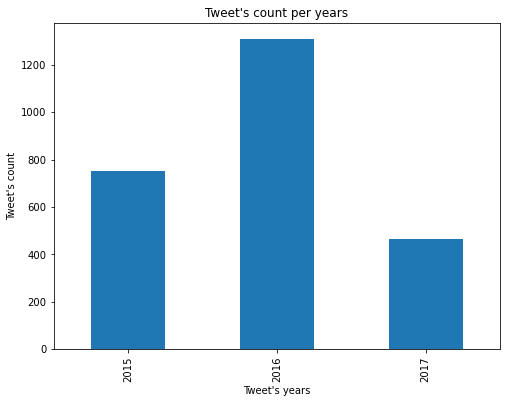

In [129]:
tweets_count_per_year.plot(kind="bar",figsize=(8,6))

plt.xlabel("Tweet's years")
plt.ylabel("Tweet's count")
plt.title("Tweet's count per years");

Our dataset span over to little years to make a good observation and give a conclusion over how the tweets evolved over the years, so we cannot the interest generated by [@dog_rates](https://twitter.com/dog_rates) account evolved over the year .      
But we can still observe a high increase of tweets in 2016 compared to 2015 and 2017. This can be explained by the viral tweet [they're good dogs Brent](http://knowyourmeme.com/memes/theyre-good-dogs-brent) which happen in 2017

#### Is a particular dog's stage more likely to raise higher level of interest ?

In order to have an answer for this question, we will explore the relationship between the dog's stages and the retweets count.

In [130]:
# Number of retweets count per dog's stage
retweets_per_stage_count = tweets_master_df[ ["stage","retweet_count"] ].groupby("stage").sum() \
                                                                    .loc[:,"retweet_count"]  \
                                                                    .sort_values(ascending=False)
retweets_per_stage_count

stage
others     5983255
pupper      590242
doggo       538500
puppo       171176
floofer      40836
Name: retweet_count, dtype: int64

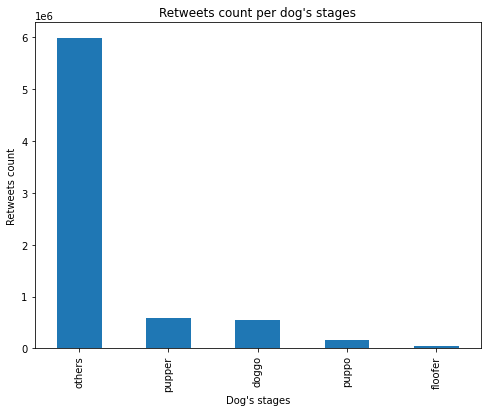

In [131]:
# Plot the number of retweets count per dog's stage
retweets_per_stage_count.plot(kind="bar", figsize=(8,6))

plt.xlabel("Dog's stages")
plt.ylabel("Retweets count")
plt.title("Retweets count per dog's stages");

Putting aside the dogs of unknow stage, we can observe that most of the dogs in the tweets are either pupper or doggo, while puppo and floofer are not represented as much as the first two stages.         
A pie chart will help us better observe the proportion of each stage in the tweets count. For a better observation, we will drop the results of unknow dog's stages.

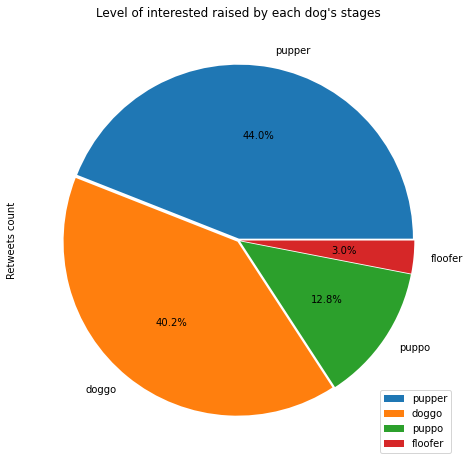

In [132]:
retweets_per_stage_count.drop("others").plot(kind="pie", 
                                             autopct='%1.1f%%',
                                             explode=[0.01, 0.01,0.01,0.01,],
                                             figsize=(8,8),
                                             legend=True
                                            )

plt.ylabel("Retweets count")
plt.title("Level of interested raised by each dog's stages");

The above chart let us easily confirm that majority of interest are raised either by doggo or pupper.

We will now analyze the proportion in order to confirm our finding, since our previous result may have be misleaded by the fact that there is more post on a specific dog's stage.

In [133]:
# Retweets count's mean per dog's stage
retweets_per_stage = tweets_master_df[ ["stage","retweet_count"] ].groupby("stage").mean() \
                                                                    .loc[:,"retweet_count"]  \
                                                                    .sort_values(ascending=False)
retweets_per_stage

stage
puppo      6847.040000
doggo      6189.655172
floofer    4083.600000
others     2753.453751
pupper     2522.401709
Name: retweet_count, dtype: float64

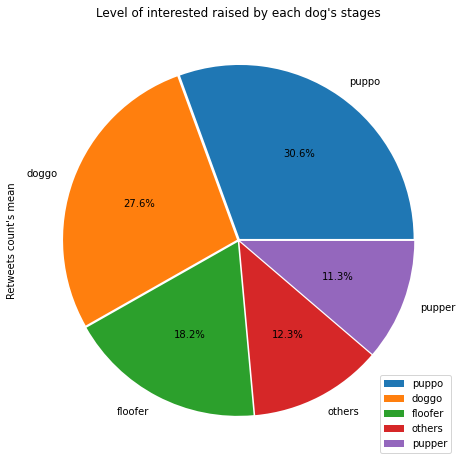

In [134]:
retweets_per_stage.plot(kind="pie", 
                        autopct='%1.1f%%',
                        explode=[0.01, 0.01,0.01,0.01,0.01],
                        figsize=(8,8),
                        legend=True
                        )

plt.ylabel("Retweets count's mean")
plt.title("Level of interested raised by each dog's stages");

We can safely conclude that puppo and doggo raise a larger level of interest, followed by floofer.

#### Is a particular dog's stage most likely to be loved ?

We will explore the relationship between the dog's stages and the score.

In [135]:
tweets_master_df.sample(3).T

,475,778,2133
tweet_id,666373753744588802,669006782128353280,673956914389192708
timestamp,2015-11-16 21:54:18+00:00,2015-11-24 04:17:01+00:00,2015-12-07 20:07:04+00:00
source,http://twitter.com/download/iphone,http://twitter.com/download/iphone,http://twitter.com/download/iphone
text,Those are sunglasses and a jean jacket. 11/10 ...,This is Tucker. He is 100% ready for the sport...,This is one esteemed pupper. Just graduated co...
rating_numerator,11,12,10
rating_denominator,10,10,10
name,None,Tucker,one
retweet_count,100,269,1069
favorite_count,194,610,2091
stage,others,others,others


In [136]:
tweets_master_df["rating_denominator"].unique()

array([ 10,  50, 120,   7, 110,  40,  80,  70,  16,   0,  20,  90,  11,
       170,   2, 150,  15, 130], dtype=int64)

In [137]:
tweets_master_df["rating_denominator"].value_counts()

10     2507
50        3
11        2
20        2
80        2
0         1
120       1
7         1
170       1
150       1
130       1
90        1
110       1
2         1
70        1
40        1
16        1
15        1
Name: rating_denominator, dtype: int64

We can observe that nearly all ratings denominator are 10.

In [138]:
tweets_master_df["rating_numerator"].unique()

array([  11,    5,   12,   10,    9,   13,    8,    3,    7,    6,   45,
         14,   27,    0,    4,  420,  144,    2,    1, 1776,   75,   24,
         26,  121,   44,   88,   84,  666,   15,   20,   80,  960,   99,
        182,  204,   17,  165,   60,   50,  143], dtype=int64)

In [139]:
tweets_master_df["rating_numerator"].value_counts()

12      592
10      508
11      506
13      361
9       173
8       113
7        62
14       59
5        39
6        33
3        20
4        17
2         9
1         8
0         2
27        2
420       2
144       1
26        1
143       1
121       1
99        1
75        1
45        1
20        1
17        1
15        1
24        1
44        1
182       1
50        1
60        1
80        1
84        1
1776      1
960       1
666       1
88        1
204       1
165       1
Name: rating_numerator, dtype: int64

Our quick search over the net to understand the meaning behing the dogs rating was unsuccessful. So we will not work on the meaning behind the numerator/denomitor, but on the basis of the rating value itself.

In [140]:
tweets_master_df["rating"] = tweets_master_df["rating_numerator"] / tweets_master_df["rating_denominator"]
tweets_master_df.sample(3).T

,1655,1505,1392
tweet_id,671504605491109889,670995969505435648,681231109724700672
timestamp,2015-12-01 01:42:28+00:00,2015-11-29 16:01:20+00:00,2015-12-27 21:52:07+00:00
source,http://twitter.com/download/iphone,http://twitter.com/download/iphone,http://twitter.com/download/iphone
text,This is Charlie. He was just informed that dog...,Yea I can't handle this job anymore your dogs ...,I just love this pic. 11/10 this pupper is goi...
rating_numerator,11,12,11
rating_denominator,10,10,10
name,Charlie,None,None
retweet_count,3866,317,540
favorite_count,7495,1175,2629
stage,others,others,pupper


Let's observe the rating we have in our dataset

In [141]:
tweets_master_df["rating"].unique()

array([1.10000000e+00, 5.00000000e-01, 1.20000000e+00, 1.00000000e+00,
       9.00000000e-01, 1.30000000e+00, 8.00000000e-01, 3.00000000e-01,
       7.00000000e-01, 6.00000000e-01, 1.40000000e+00, 2.70000000e+00,
       0.00000000e+00, 4.00000000e-01, 4.20000000e+01, 2.00000000e-01,
       1.00000000e-01, 1.77600000e+02, 7.50000000e+00, 3.42857143e+00,
       2.60000000e+00, 6.66000000e+01, 1.50000000e+00, 1.25000000e+00,
                  inf, 8.18181818e-01, 1.82000000e+01, 1.70000000e+00,
       7.33333333e-01, 6.36363636e-01])

In [142]:
tweets_master_df["rating"].value_counts()

1.200000      596
1.100000      511
1.000000      510
1.300000      361
0.900000      173
0.800000      113
0.700000       61
1.400000       59
0.500000       40
0.600000       33
0.300000       20
0.400000       15
0.200000       11
0.100000        7
2.700000        2
0.000000        2
42.000000       2
3.428571        1
0.818182        1
66.600000       1
inf             1
2.600000        1
18.200000       1
1.500000        1
7.500000        1
1.700000        1
177.600000      1
0.733333        1
1.250000        1
0.636364        1
Name: rating, dtype: int64

We have `inf` as value in our rating, which mean some of our `rating_denomitor` is 0. We will drop those samples in order to not be stuck when we will do some analysis

In [143]:
tweets_master_df["rating"].nunique()

30

In [144]:
# Drop sample with 0 as value in rating_denomitor
tweets_master_df = tweets_master_df[ tweets_master_df["rating_denominator"]!=0 ]

In [145]:
# Making sure we don't have inf value anymore
tweets_master_df["rating"].unique()

array([1.10000000e+00, 5.00000000e-01, 1.20000000e+00, 1.00000000e+00,
       9.00000000e-01, 1.30000000e+00, 8.00000000e-01, 3.00000000e-01,
       7.00000000e-01, 6.00000000e-01, 1.40000000e+00, 2.70000000e+00,
       0.00000000e+00, 4.00000000e-01, 4.20000000e+01, 2.00000000e-01,
       1.00000000e-01, 1.77600000e+02, 7.50000000e+00, 3.42857143e+00,
       2.60000000e+00, 6.66000000e+01, 1.50000000e+00, 1.25000000e+00,
       8.18181818e-01, 1.82000000e+01, 1.70000000e+00, 7.33333333e-01,
       6.36363636e-01])

Now we will observe how the ratings are distributed based on the dog's stages.

In [146]:
# Mean rating per dog's stage
mean_rating_per_stage = tweets_master_df.groupby("stage") \
                                         .mean() \
                                         .drop("others")  \
                                        .loc[:,"rating"]  \
                                       .sort_values(ascending=False)

mean_rating_per_stage

stage
puppo      1.208000
floofer    1.180000
doggo      1.177011
pupper     1.082051
Name: rating, dtype: float64

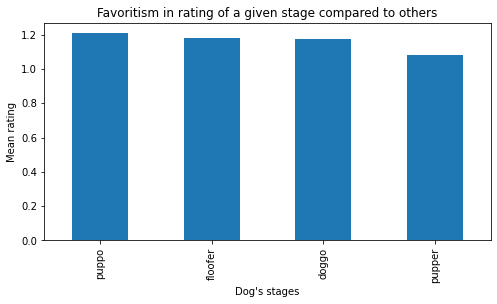

In [147]:
# Plot the mean rating per dog's stage 
mean_rating_per_stage.plot(kind="bar", figsize=(8,4))

plt.xlabel("Dog's stages")
plt.ylabel("Mean rating")
plt.title("Favoritism in rating of a given stage compared to others");

From this plot, we can observe that the ratings per stage are nearly the same. We can conclude that there is no bias for/against a particular dog stage.            
However, we can see that Puppo tend to a have higher rating compared to other stages, closely followed by Floofer and Doggo.

#### Is the score influenced by the level of interest ?

We will be interested here by the relationship between the rating and the retweet count.

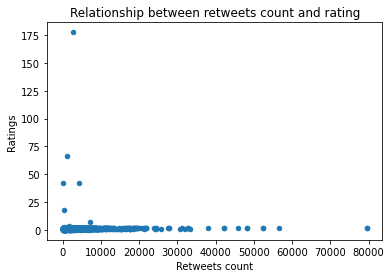

In [148]:
tweets_master_df.plot(kind="scatter",x="retweet_count",y="rating")
plt.xlabel("Retweets count")
plt.ylabel("Ratings")
plt.title("Relationship between retweets count and rating");

There is little linear correlation between the retweets count and the rating. So the ones is not (linearly) influenced by the other.                        
We will also check the relationship between favorites count and the rating, to see if the rating is influenced by how much the dog was loved.

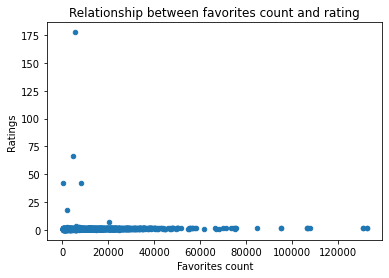

In [149]:
tweets_master_df.plot(kind="scatter",x="favorite_count",y="rating")
plt.xlabel("Favorites count")
plt.ylabel("Ratings")
plt.title("Relationship between favorites count and rating");

We can also notice that there is no (linear) relationship between the rating and the favorites count.

Based on the above two plots, we can safely conclude that the rating is not influenced by neither the favorites count nor the retweets count.

#### Is the ratings influenced by the day period ?

Here, we are trying to determine if the day period (morning, miday, evening, afternoon, ...) somehow has an impact on the ratings.

Since we are going to work with day periods, we will create a new feature based on our available datas.

In [150]:
tweets_master_df.head(3).T

,0,1,2
tweet_id,728046963732717569,781661882474196992,745057283344719872
timestamp,2016-05-05 02:21:37+00:00,2016-09-30 01:08:10+00:00,2016-06-21 00:54:33+00:00
source,http://twitter.com/download/iphone,http://twitter.com/download/iphone,http://twitter.com/download/iphone
text,This is Raymond. He controls fountains with hi...,Who keeps sending in pictures without dogs in ...,This is Oliver. He's downright gorgeous as hel...
rating_numerator,11,5,12
rating_denominator,10,10,10
name,Raymond,None,Oliver
retweet_count,1328,3129,2585
favorite_count,4722,11634,7945
stage,others,others,others


In [151]:
# tweets_master_df["timestamp"].value_counts()

In [152]:
# """
#     Generating new features for our samples, in order to answer day periods (morning, miday, evening, afternoon, ...)
#     related questions.
        
#     Code based on the courses given by Prof @Stanley Omeike on OneCampus Academy.
# """

# dCol = tweets_master_df["timestamp"].astype(str)
# dCol

# # dates = [( datetime.ctime(parse(x[0:-3])), x[-2:] ) for x in dCol]

# # print("dates[:2] : ")
# # print(dates[:2])

In [153]:
# dCol2 = tweets_master_df["timestamp"].dt.strftime("%Y-%m-%d %I:%M:%S %p").astype(str) #strftime("%Y-%m-%d %H:%M:%S")
# dCol2

In [154]:
# def operate_datetime_feature_engineering(df:pd.DataFrame, datetime_column:str, verbose=False)->pd.DataFrame:
#     """
#         Generate new features for our samples, in order to answer questions related to :
#             - day periods (morning, miday, evening, afternoon, ...)
#             - day (monday, tuesday, ...)
#             - month (Jan, Feb, ...)

#         Code based on the courses given by Prof @Stanley Omeike on OneCampus Academy.
        
#         @param df:pd.DataFrame : the dataframe in which to do the feature engineering
#         @param datetime_column:str : column based on which to do the feature engineering
        
#         @return : the new dataframe, containing the generated columns
#     """

#     # standardize the format of the column, and parse it to str in order to allow further work on it
#     dCol = tweets_master_df[datetime_column].dt.strftime("%Y-%m-%d %I:%M:%S %p").astype(str) #tweets_master_df["timestamp"].astype(str)
#     #dCol

#     # print(dates[:2] ) will give something like : [('Sat Jul 26 02:30:00 2008', 'PM'), ('Tue Jul 31 10:57:00 2018', 'AM')]
#     dates = [( datetime.ctime(parse(x[0:-3])), x[-2:] ) for x in dCol]

# #     print("dates[:2] : ")
# #     print(dates[:2])
    
#     days = []
#     months = []
#     periods = []

#     unprocesseds = []

#     for row in dates:
#         day = row[0][0:4]
#         month = row[0][4:7]
#         time = int(row[0][11:13])

#         if row[1]=='AM' and time<=4:
#             period = 'Night (after midnight)'
#         elif row[1]=='AM' and time<=7:
#             period = "Morning"
#         elif row[1]=='AM' and time>7:
#             period = "Day Time"
#         elif row[1] =='PM' and time<=4:
#             period = 'Afternoon'
#         elif row[1] =='PM' and time<=6:
#             period = 'Evening' 
#         elif row[1] =='PM' and (time>6 and time<=10):
#             period = 'Night'
#         elif row[1] =='PM' and time>10:
#             period = 'Near Midnight'
#         else:
#             period = "TODO"
#             unprocesseds.append(row[0]+" "+row[1])

#         days.append(day)
#         months.append(month)
#         periods.append(period)
    
#     if(len(unprocesseds)>0):
#         print("unprocesseds")
#         print(unprocesseds)
#         print("len(unprocesseds)")
#         print(len(unprocesseds))
    
#     df['month'] = months
#     df['day'] = days
#     df['period']= periods
    
#     if(verbose):
#         df.sample(3).T
        
#     return df

In [155]:
tweets_master_df = operate_datetime_feature_engineering(tweets_master_df, datetime_column="timestamp")
tweets_master_df.sample(3).T

,2388,1676,2153
tweet_id,775842724423557120,879674319642796034,832273440279240704
timestamp,2016-09-13 23:44:54+00:00,2017-06-27 12:14:36+00:00,2017-02-16 17:00:25+00:00
source,http://twitter.com/download/iphone,http://twitter.com/download/iphone,http://twitter.com/download/iphone
text,This is Blue. He was having an average day unt...,@RealKentMurphy 14/10 confirmed,Say hello to Smiley. He's a blind therapy dogg...
rating_numerator,12,14,14
rating_denominator,10,10,10
name,Blue,None,Smiley
retweet_count,3116,10,2673
favorite_count,13022,315,12385
stage,others,others,doggo


In [160]:
mean_rating_per_period = tweets_master_df.groupby("period")  \
                                         .mean()   \
                                         .loc[:,"rating"]  \
                                         .sort_values(ascending=False)

mean_rating_per_period

period
Morning                   2.115278
Afternoon                 1.595168
Night (start)             1.394315
Near Midnight             1.153887
Evening                   1.111471
Day Time                  1.111148
Night (after midnight)    1.024976
Name: rating, dtype: float64

We can already observe that theoretically, the best period to tweet a dog's post in order to maximize the chance of having a high rating is the Morning, followed by the Afternoon; worst case scenario, the post should be done at the start of Night. A chart will help us better observe the situation.

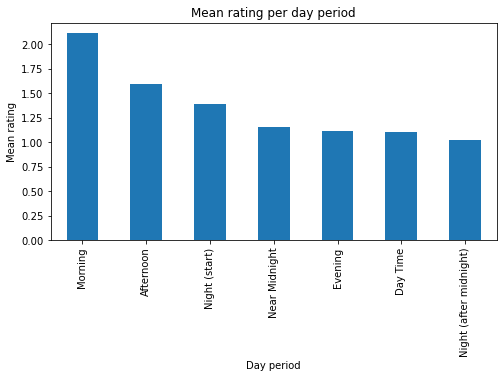

In [165]:
mean_rating_per_period.plot(kind="bar", figsize=(8,4))

plt.xlabel("Day period")
plt.ylabel("Mean rating")

plt.title("Mean rating per day period");

The difference in ratings based on the day period may be related to the availability of the rater, that is to say how much time and care the rater can devote to evaluate the dog before providing a rating.

We have deduced that the day period have impact on the rating. Now we will push our investigation further to see how ratings vary based not only on day period but also the breed.

In [171]:
mean_rating_per_period_and_breed = tweets_master_df.groupby(["period","breed"])  \
                                         .mean()   \
                                         .loc[:,"rating"]  #\
                                         #.sort_values(ascending=False)

mean_rating_per_period_and_breed

period         breed                  
Afternoon      Afghan_hound               0.80
               Airedale                   1.15
               Appenzeller                1.30
               Basset                     1.22
               Beagle                     1.10
                                          ... 
Night (start)  Toy_poodle                 1.20
               Welsh_springer_spaniel     0.95
               Whippet                    1.20
               Wire-haired_fox_terrier    1.20
               Yorkshire_terrier          0.90
Name: rating, Length: 441, dtype: float64

<AxesSubplot:xlabel='period,breed'>

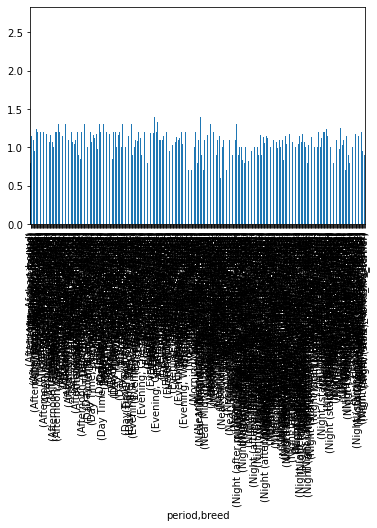

In [172]:
mean_rating_per_period_and_breed.plot(kind="bar")

In [ ]:
# TODO : continue the part above 

#### Is the number of images associated wih a post help increase its rating ?

We will investigate the mean rating based on the number of images per tweet.

In [173]:
# Mean rating per dog images
mean_rating_per_images = tweets_master_df.groupby("img_num")  \
                                         .mean()   \
                                         .loc[:,"rating"]  \
                                         .sort_values(ascending=False)

mean_rating_per_images

img_num
4.0    1.240000
3.0    1.194781
2.0    1.147283
1.0    1.092689
Name: rating, dtype: float64

Text(0.5, 1.0, 'Mean rating per image number')

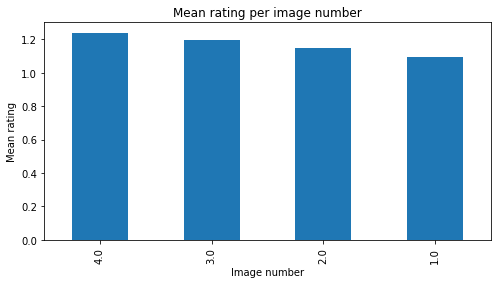

In [175]:
# Plot mean rating per dog images
mean_rating_per_images.plot(kind="bar", figsize=(8,4))

plt.xlabel("Image number")
plt.ylabel("Mean rating")
plt.title("Mean rating per image number")

The number of images don't have a **major** impact in the rating given. But they do however have some little effect, since we can observe a slight increase in the mean rating each time the number of images is incremented.

### Visualization